<a href="https://colab.research.google.com/github/IsaacFigNewton/Taxonomic-Span-Categorization/blob/main/HDBSCAN_for_ATC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config

In [69]:
!pip install hdbscan

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
import random
import spacy
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import nltk
from nltk.corpus import gutenberg
import hdbscan

nltk.download("gutenberg")

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

# Helpers

In [71]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723
    Licensed under Creative Commons Attribution-Share Alike

    If the graph is a tree this will return the positions to plot this in a
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch
    - if the tree is directed and this is not given,
      the root will be found and used
    - if the tree is directed and this is given, then
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given,
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children)!=0:
            pos = _hierarchy_pos(
                G,
                children[0],
                width = width,
                vert_gap = vert_gap,
                vert_loc = vert_loc-vert_gap,
                xcenter=0,
                pos=pos,
                parent = root
            )
            pos = _hierarchy_pos(
                G,
                children[1],
                width = width,
                vert_gap = vert_gap,
                vert_loc = vert_loc-vert_gap,
                xcenter=10,
                pos=pos,
                parent = root
            )
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [ ]:
def dendrogram_to_graph(Z, embeddings, labels, maximum_intercluster_distance=None):
    """
    Convert a dendrogram linkage matrix into a NetworkX graph.
    Each node stores its centroid and 4 maximally distant tokens as metadata.

    Args:
        Z: linkage matrix
        embeddings: original embeddings
        labels: labels for leaf nodes
        maximum_intercluster_distance: (float or None) maximum intercluster distance to expand
                                     nodes with distances above this are pruned.
                                     If None, uses 95th percentile of distances
    """
    G = nx.DiGraph()
    n_samples = len(embeddings)
    
    # Auto-determine threshold if not provided
    if maximum_intercluster_distance is None:
        distances = Z[:, 2]
        maximum_intercluster_distance = np.percentile(distances, 95)
        print(f"Auto-selected maximum_intercluster_distance: {maximum_intercluster_distance:.6f}")

    def get_cluster_members(node_id, Z, n_samples):
        """Recursively get all leaf node members of a cluster"""
        if node_id < n_samples:  # leaf node
            return [node_id]
        
        # Internal node - get index in linkage matrix
        linkage_idx = int(node_id - n_samples)
        if linkage_idx >= len(Z):
            return []
            
        left_child = int(Z[linkage_idx, 0])
        right_child = int(Z[linkage_idx, 1])
        
        members = []
        members.extend(get_cluster_members(left_child, Z, n_samples))
        members.extend(get_cluster_members(right_child, Z, n_samples))
        return members

    def find_maximally_distant_tokens(member_indices, embeddings, n_tokens=4):
        """Find n_tokens that are maximally distant from each other"""
        if len(member_indices) <= n_tokens:
            return member_indices
        
        member_embeddings = embeddings[member_indices]
        
        # Start with the two most distant points
        distances = euclidean_distances(member_embeddings)
        max_dist_idx = np.unravel_index(np.argmax(distances), distances.shape)
        selected_indices = [member_indices[max_dist_idx[0]], member_indices[max_dist_idx[1]]]
        
        # Greedily add remaining points that maximize minimum distance to selected points
        remaining_indices = [idx for idx in member_indices if idx not in selected_indices]
        
        for _ in range(n_tokens - 2):
            if not remaining_indices:
                break
                
            max_min_dist = -1
            best_idx = None
            
            for candidate_idx in remaining_indices:
                candidate_emb = embeddings[candidate_idx:candidate_idx+1]
                selected_embs = embeddings[selected_indices]
                min_dist = np.min(euclidean_distances(candidate_emb, selected_embs))
                
                if min_dist > max_min_dist:
                    max_min_dist = min_dist
                    best_idx = candidate_idx
            
            if best_idx is not None:
                selected_indices.append(best_idx)
                remaining_indices.remove(best_idx)
        
        return selected_indices

    # Add leaf nodes
    for i, (label, emb) in enumerate(zip(labels, embeddings)):
        G.add_node(i, label=label, centroid=emb.tolist(), representative_tokens=[labels[i]])

    # Track which nodes we're creating
    created_nodes = set(range(n_samples))  # All leaf nodes exist
    
    # Internal nodes - process in order to ensure dependencies exist
    for i, (c1, c2, dist, sample_count) in enumerate(Z):
        node_id = n_samples + i
        c1, c2 = int(c1), int(c2)
        
        # Skip if distance exceeds threshold
        if dist > maximum_intercluster_distance:
            continue
        
        # Skip if children don't exist (were pruned)
        if c1 not in created_nodes or c2 not in created_nodes:
            continue

        # Get all members of this cluster
        cluster_members = get_cluster_members(node_id, Z, n_samples)
        
        if not cluster_members:
            continue
            
        # Find 4 maximally distant tokens
        max_distant_indices = find_maximally_distant_tokens(cluster_members, embeddings, 4)
        representative_tokens = [labels[idx] for idx in max_distant_indices]
        
        # Calculate centroid from representative tokens
        representative_embeddings = embeddings[max_distant_indices]
        centroid = np.mean(representative_embeddings, axis=0)

        G.add_node(node_id, centroid=centroid.tolist(), size=sample_count, 
                   representative_tokens=representative_tokens)
        
        # Add edges to children
        G.add_edge(node_id, c1, weight=dist)
        G.add_edge(node_id, c2, weight=dist)
        
        # Mark this node as created
        created_nodes.add(node_id)

    return G


def assign_nearest_words(G, df):
    word_embeddings = df.values
    words = df.index.tolist()

    for node, data in G.nodes(data=True):
        if 'representative_tokens' in data and len(data['representative_tokens']) > 0:
            # Use the first representative token as the nearest word
            G.nodes[node]["nearest_word"] = data['representative_tokens'][0]
        else:
            # Fallback to original logic for leaf nodes
            centroid = np.array(data["centroid"]).reshape(1, -1)
            sims = euclidean_distances(centroid, word_embeddings)[0]
            best_idx = np.argmin(sims)  # Use argmin for euclidean distance
            best_word = words[best_idx]
            G.nodes[node]["nearest_word"] = best_word
    return G


def draw_taxonomy(G, maximum_intercluster_distance=None):
    """
    Plot the taxonomy graph.

    Args:
        G: NetworkX DiGraph with nodes containing 'nearest_word'
        maximum_intercluster_distance: display parameter for title only
    """
    if len(G.nodes()) == 0:
        print("Empty graph - no nodes to display")
        return
        
    # Find root(s) — nodes with no parents (in-degree = 0)
    try:
        roots = [n for n in G.nodes() if G.in_degree(n) == 0]
        if not roots:
            print("No root nodes found - graph may be disconnected")
            return
        root = roots[0]  # Use first root if multiple
    except:
        print("Error finding root nodes")
        return

    # Use all nodes in the graph for drawing
    subG = G
    
    try:
        pos = hierarchy_pos(subG, root)
    except Exception as e:
        print(f"Error creating hierarchy layout: {e}")
        # Fallback to spring layout
        pos = nx.spring_layout(subG)
    
    # Create labels that show representative tokens for internal nodes
    labels = {}
    for n in subG.nodes():
        node_data = G.nodes[n]
        if 'representative_tokens' in node_data and len(node_data['representative_tokens']) > 1:
            # Show all representative tokens (up to 4), truncated if too long
            tokens = node_data['representative_tokens'][:4]
            # Truncate long tokens for display
            display_tokens = [token[:15] + '...' if len(token) > 15 else token for token in tokens]
            labels[n] = '\\n'.join(display_tokens)  # Use newlines for better display
        else:
            nearest_word = node_data.get("nearest_word", str(n))
            # Truncate long words
            if len(nearest_word) > 15:
                nearest_word = nearest_word[:15] + '...'
            labels[n] = nearest_word

    plt.figure(figsize=(20, 12))
    nx.draw(subG, pos, with_labels=True, labels=labels, node_size=1200, 
            node_color="lightblue", font_size=6, font_weight="bold")
    
    distance_str = f"{maximum_intercluster_distance:.6f}" if maximum_intercluster_distance is not None else "Auto"
    plt.title(f"Taxonomy - Max Intercluster Distance: {distance_str}\\nNodes: {len(subG.nodes())}, Edges: {len(subG.edges())}")
    plt.show()

In [ ]:
class TaxonomyPipeline:
    def __init__(self, model_name="all-MiniLM-L6-v2", hdbscan_params=None):
        self.nlp = spacy.load("en_core_web_sm")
        self.embedder = SentenceTransformer(model_name)
        # allow user to tune HDBSCAN (e.g. min_cluster_size, metric, cluster_selection_method, etc.)
        self.hdbscan_params = hdbscan_params or {"min_cluster_size": 20}
        self.clusterer = None
        self.noun_chunks = None

    def process(self, text_or_texts, maximum_intercluster_distance=None):
        """
        Process a single string OR a list of plaintext corpora.
        Returns the graph after building taxonomy.

        Uses HDBSCAN to obtain the single-linkage tree (SciPy linkage format)
        via clusterer.single_linkage_tree_.to_numpy() and passes that to
        dendrogram_to_graph(...) so the rest of your pipeline is unchanged.
        
        Args:
            text_or_texts: string or list of strings to process
            maximum_intercluster_distance: maximum distance threshold for taxonomy pruning.
                                         If None, uses 95th percentile of distances automatically.
        """
        # Normalize input to list
        if isinstance(text_or_texts, str):
            corpora = [text_or_texts]
        elif isinstance(text_or_texts, list):
            corpora = text_or_texts
        else:
            raise TypeError("Input must be a string or list of strings.")

        # Step 1: Extract noun chunks from all corpora
        noun_chunks = []
        for text in corpora:
            doc = self.nlp(text)
            noun_chunks.extend([t.text.strip() for t in doc])

        if len(noun_chunks) == 0:
            # handle empty case gracefully
            return None

        # Store for dendrogram plotting
        self.noun_chunks = noun_chunks

        # Step 2: Get embeddings
        embeddings = self.embedder.encode(noun_chunks)

        # Step 3: Build dataframe (all noun chunks pooled)
        df = pd.DataFrame(embeddings, index=noun_chunks)

        # Step 4: Normalize
        pipeline = Pipeline([("scaler", StandardScaler())])
        normalized_embeddings = pipeline.fit_transform(embeddings)

        # Step 5: Clustering with HDBSCAN and extract single-linkage tree (SciPy linkage)
        # Note: the hdbscan implementation builds a single-linkage tree internally;
        # the SingleLinkageTree object exposes a .to_numpy() that returns a SciPy-style linkage.
        clusterer = hdbscan.HDBSCAN(**self.hdbscan_params)
        clusterer.fit(normalized_embeddings)
        
        # Store clusterer for dendrogram plotting
        self.clusterer = clusterer

        try:
            # SingleLinkageTree.to_numpy() returns SciPy-style linkage (n_samples-1, 4)
            Z = clusterer.single_linkage_tree_.to_numpy()
        except Exception as e:
            # If something unexpected happens, give a helpful error
            raise RuntimeError(
                "Unable to extract single-linkage tree from HDBSCAN. "
                "Make sure you have a recent 'hdbscan' installed. "
                f"Underlying error: {e}"
            )

        # Step 6: Build graph (re-using your existing conversion with new parameter)
        G = dendrogram_to_graph(Z, embeddings, noun_chunks, maximum_intercluster_distance)

        # Step 7: Assign nearest words
        G = assign_nearest_words(G, df)

        return G

    def draw_dendrogram(self, **kwargs):
        """
        Draw the dendrogram using HDBSCAN's built-in plotting functionality.
        Must be called after process() has been run.
        
        Args:
            **kwargs: Additional arguments to pass to the dendrogram plot
        """
        if self.clusterer is None:
            raise ValueError("Must run process() first before drawing dendrogram")
        
        if not hasattr(self.clusterer, 'single_linkage_tree_'):
            raise ValueError("No single linkage tree found. Make sure HDBSCAN clustering completed successfully")
        
        # Use HDBSCAN's built-in dendrogram plotting
        self.clusterer.single_linkage_tree_.plot(
            cmap='viridis', 
            colorbar=True,
            **kwargs
        )
        plt.title("HDBSCAN Single Linkage Tree Dendrogram")
        plt.xlabel("Sample Index")
        plt.ylabel("Distance")
        plt.show()

# Test

In [ ]:
files = gutenberg.fileids()
corpora = [gutenberg.raw(fid)[:1000] for fid in files]

pipeline = TaxonomyPipeline(hdbscan_params={"min_cluster_size":2})
# Use automatic threshold selection (95th percentile)
G = pipeline.process(corpora, maximum_intercluster_distance=None)

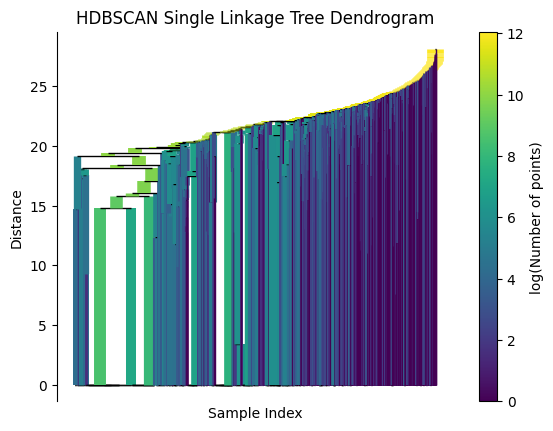

In [75]:
pipeline.draw_dendrogram()

In [ ]:
# Draw taxonomy with automatic threshold
draw_taxonomy(G)

In [ ]:
# Example with different thresholds
# First get the distance statistics to understand good threshold values
Z = pipeline.clusterer.single_linkage_tree_.to_numpy()
distances = Z[:, 2]
print(f"Distance percentiles:")
print(f"75th: {np.percentile(distances, 75):.6f}")
print(f"85th: {np.percentile(distances, 85):.6f}")  
print(f"95th: {np.percentile(distances, 95):.6f}")

# Create taxonomy with 85th percentile threshold for more pruning
print(f"\n--- Testing with 85th percentile threshold ---")
G_85 = pipeline.process(corpora, maximum_intercluster_distance=np.percentile(distances, 85))
draw_taxonomy(G_85, maximum_intercluster_distance=np.percentile(distances, 85))

In [ ]:
# Debug: Let's examine the linkage matrix to understand the distance values
if pipeline.clusterer and hasattr(pipeline.clusterer, 'single_linkage_tree_'):
    Z = pipeline.clusterer.single_linkage_tree_.to_numpy()
    print("Linkage matrix shape:", Z.shape)
    print("\nFirst 10 rows of linkage matrix (child1, child2, distance, size):")
    print(Z[:10])
    print(f"\nDistance range: {Z[:, 2].min():.6f} to {Z[:, 2].max():.6f}")
    print(f"Mean distance: {Z[:, 2].mean():.6f}")
    print(f"Median distance: {np.median(Z[:, 2]):.6f}")
    
    # Check some specific distance values
    distances = Z[:, 2]
    print(f"\nPercentiles:")
    print(f"50th percentile: {np.percentile(distances, 50):.6f}")
    print(f"75th percentile: {np.percentile(distances, 75):.6f}")
    print(f"90th percentile: {np.percentile(distances, 90):.6f}")
    print(f"95th percentile: {np.percentile(distances, 95):.6f}")
    
    # Debug: Let's also examine the graph structure
    print(f"\nGraph nodes: {len(G.nodes())}")
    print(f"Graph edges: {len(G.edges())}")
    print(f"Number of samples: {len(pipeline.noun_chunks)}")
    
    # Check a few node details
    print("\nSample of nodes with their data:")
    for i, (node, data) in enumerate(list(G.nodes(data=True))[:5]):
        print(f"Node {node}: {data}")
    
else:
    print("No linkage tree available")